# Amelioration du modele

Afin d'ameliorer mon modele, j'ajoute un jeu de données par ville bresilienne

Je pense que les zones densément peuplés sont mieux désservies, les informations de population par exemple sont interessantes

In [20]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
import os

from unidecode import unidecode

In [21]:
clean = '../../datas/CLEAN/E2/'

con = sqlite3.connect(clean + 'E2.db')
df = pd.read_sql('select * from base_modele_ameliore', con, index_col='index')

con.close()

df.head()

,distance,estimated_delay,price,freight_value,customer_city,customer_state,seller_city,seller_state,weight,volume,...,February,January,July,June,March,May,November,October,September,shipping_delay
index,,,,,,,,,,,,,,,,,,,,,
0,342.735016,28.566238,21.99,14.110000,rio de janeiro,RJ,sao paulo,SP,125.0,1040.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000926
1,373.207245,22.309410,412.00,27.719999,atibaia,SP,curitiba,PR,6000.0,36000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.149213
2,373.207245,22.309410,412.00,27.719999,atibaia,SP,curitiba,PR,6000.0,36000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.149213
3,324.354340,17.523668,420.00,24.240000,sao paulo,SP,curitiba,PR,3000.0,18000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.436667
4,816.780701,22.359861,412.00,26.260000,belo horizonte,MG,curitiba,PR,3000.0,18000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.238160


### Recuperation du nombre de compagnies de transport

In [22]:
df_pop = pd.read_csv('modele_amelioration_dataset/BRAZIL_CITIES.csv', sep=';')

# Filtre les colonnes interessantes
df_pop_cols = ['CITY', 'STATE', 'CAPITAL', 'IBGE_RES_POP', 'ESTIMATED_POP', 'RURAL_URBAN', 'POP_GDP', 'COMP_H', 'POST_OFFICES']
df_pop = df_pop[df_pop_cols]

# Creation d'un id
df_pop.CITY = df_pop.CITY.apply(str.lower).apply(unidecode)
df_pop['id'] = df_pop.CITY + ' ' + df_pop.STATE
df_pop_cols = ['CAPITAL', 'IBGE_RES_POP', 'ESTIMATED_POP', 'RURAL_URBAN', 'POP_GDP', 'COMP_H', 'POST_OFFICES']
df_pop = df_pop.drop(columns=['CITY', 'STATE'])

df_pop.id.head(1)

0    abadia de goias GO
Name: id, dtype: object

In [23]:
df['customer_id'] = df.customer_city + ' ' + df.customer_state
df['seller_id'] = df.seller_city + ' ' + df.seller_state

df = df.merge(df_pop, how='left', left_on='customer_id', right_on='id')
df.head(1)

,distance,estimated_delay,price,freight_value,customer_city,customer_state,seller_city,seller_state,weight,volume,...,customer_id,seller_id,CAPITAL,IBGE_RES_POP,ESTIMATED_POP,RURAL_URBAN,POP_GDP,COMP_H,POST_OFFICES,id
0,342.735016,28.566238,21.99,14.11,rio de janeiro,RJ,sao paulo,SP,125.0,1040.0,...,rio de janeiro RJ,sao paulo SP,1.0,6320446.0,6688927.0,Urbano,6498837.0,4825.0,120.0,rio de janeiro RJ


(<AxesSubplot:>,
 CAPITAL         -0.057108
 IBGE_RES_POP    -0.201912
 ESTIMATED_POP   -0.202993
 POP_GDP         -0.203342
 COMP_H          -0.232891
 POST_OFFICES    -0.200987
 dtype: float64)

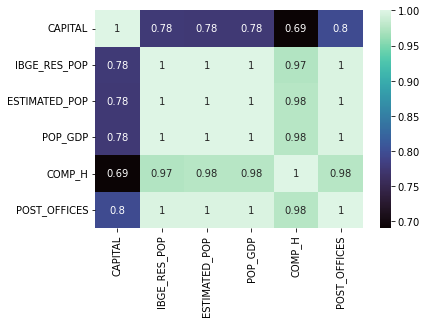

In [24]:
sns.heatmap(
    df[df_pop_cols].corr(),
    cmap='mako', annot=True
), df[df_pop_cols].corrwith(df.shipping_delay)

Etant donné que les variables sont toutes très corrélées entre elles, je ne prends que la meilleure correlation avec la cible

In [25]:
df_pop_cols.remove('COMP_H')
df = df.drop(columns=df_pop_cols + ['id', 'customer_id', 'customer_city', 'customer_state'], errors='ignore')
df = df.rename(columns={
    'COMP_H': 'customer_transport'
})
df.head(1)

,distance,estimated_delay,price,freight_value,seller_city,seller_state,weight,volume,cool_stuff,pet_shop,...,July,June,March,May,November,October,September,shipping_delay,seller_id,customer_transport
0,342.735016,28.566238,21.99,14.11,sao paulo,SP,125.0,1040.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000926,sao paulo SP,4825.0


Remplacement des valeurs vides par la mediane

In [26]:
print(df.customer_transport.isna().sum())
df.customer_transport = df.customer_transport.fillna(df.customer_transport.median())
df.customer_transport.isna().sum()

641


0

### Meme traitement pour les vendeurs

In [27]:
df_pop_cols = ['CAPITAL', 'IBGE_RES_POP', 'ESTIMATED_POP', 'RURAL_URBAN', 'POP_GDP', 'COMP_H', 'POST_OFFICES']
df = df.merge(df_pop, how='left', left_on='seller_id', right_on='id')

df[df_pop_cols].corrwith(df.shipping_delay)

CAPITAL         -0.091344
IBGE_RES_POP    -0.103575
ESTIMATED_POP   -0.103477
POP_GDP         -0.103488
COMP_H          -0.103562
POST_OFFICES    -0.103892
dtype: float64

Etant donné que les variables sont toutes très corrélées entre elles, je ne prends que la meilleure correlation avec la cible

In [28]:
df_pop_cols.remove('POST_OFFICES')
df = df.drop(columns=df_pop_cols + ['id', 'seller_id', 'seller_city', 'seller_state'], errors='ignore')
df = df.rename(columns={
    'POST_OFFICES': 'seller_post'
})
df.head(1)

,distance,estimated_delay,price,freight_value,weight,volume,cool_stuff,pet_shop,moveis_decoracao,perfumaria,...,July,June,March,May,November,October,September,shipping_delay,customer_transport,seller_post
0,342.735016,28.566238,21.99,14.11,125.0,1040.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000926,4825.0,225.0


Remplacement des valeurs vides par la mediane

In [29]:
print(df.seller_post.isna().sum())
df.seller_post = df.seller_post.fillna(df.seller_post.median())
df.seller_post.isna().sum()

2412


0

In [30]:
y = df.pop('shipping_delay')
y = y.astype('float')

print(df.memory_usage().sum())
numeric_cols = df.select_dtypes(include=np.number).columns

# optimisation de taille
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, downcast="float")
y = y.apply(pd.to_numeric, downcast="float")

print(df.memory_usage().sum())

df.shape

80324088
40559688


(99411, 100)

In [40]:
df[['distance',	'estimated_delay',	'price',	'freight_value',	'weight',	'volume', 'customer_transport',	'seller_post']].corr()

,distance,estimated_delay,price,freight_value,weight,volume,customer_transport,seller_post
distance,1.000000,0.530157,0.077569,0.479746,-0.033619,-0.031326,-0.311517,-0.080229
estimated_delay,0.530157,1.000000,0.079040,0.345490,0.061955,0.060002,-0.283373,-0.155631
price,0.077569,0.079040,1.000000,0.347224,0.201226,0.137467,-0.031883,-0.117471
freight_value,0.479746,0.345490,0.347224,1.000000,0.371465,0.302913,-0.208344,-0.151513
weight,-0.033619,0.061955,0.201226,0.371465,1.000000,0.833840,-0.007532,-0.063570
volume,-0.031326,0.060002,0.137467,0.302913,0.833840,1.000000,-0.000211,-0.048029
customer_transport,-0.311517,-0.283373,-0.031883,-0.208344,-0.007532,-0.000211,1.000000,0.015152
seller_post,-0.080229,-0.155631,-0.117471,-0.151513,-0.063570,-0.048029,0.015152,1.000000


# Feature selection et preprocessing

### Feature selection

Si je veux faire un formulaire avec mes données, je souhaite réduire au maximum mon nombre de variables 

( à 20 variables etant donné que les mois et produits sont très simples à renseigner )

La moitié des variables ont en absolu moins de 0.01 de correlation avec le temps de livraison

In [31]:
df.shape[1], (abs(df.corrwith(y)).sort_values(ascending=False) < 0.01).sum()

(100, 48)

65 variables on une P-value inferieures à 0.05

In [32]:
df.shape[1], (pd.Series(f_regression(df, y)[1]).sort_values(ascending=True) < 0.05).sum()

(100, 69)

In [33]:
df_cols = df.columns

selector = SelectKBest(f_regression, k=20)
X = pd.DataFrame(selector.fit_transform(df, y))
X.columns = df_cols[selector.get_support()]
print(X.shape, y.shape)
X.head(1)

(99411, 20) (99411,)


,distance,estimated_delay,price,freight_value,weight,volume,ferramentas_jardim,utilidades_domesticas,moveis_escritorio,Friday,August,December,February,January,July,June,March,November,customer_transport,seller_post
0,342.735016,28.566238,21.99,14.11,125.0,1040.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4825.0,225.0


In [34]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
X.to_sql(name='preprocessor_amelioration_input', con=con, if_exists='replace')
con.close()

### Pipeline

Certaines colonnes sont deja sous forme de OneHotEncoder

C'est pourquoi je ne les traite pas

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('do_nothing', SimpleImputer(strategy='constant', fill_value=-1))
])

categorical_features = X.columns[(~(X.nunique() > 2)).to_list()]
numeric_features = X.columns[(X.nunique() > 2).to_list()]

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])
numeric_features

Index(['distance', 'estimated_delay', 'price', 'freight_value', 'weight',
       'volume', 'customer_transport', 'seller_post'],
      dtype='object')

In [36]:
X = pd.DataFrame(preprocessor.fit_transform(X))
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.377445,0.703368,-0.829783,-0.398373,-0.417097,-0.494983,0.100721,1.681591,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.313977,-0.088532,3.380010,1.051197,0.583322,0.443892,-0.562972,-0.148776,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.313977,-0.088532,3.380010,1.051197,0.583322,0.443892,-0.562972,-0.148776,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.415728,-0.694243,3.466362,0.680550,0.072470,-0.039510,2.196971,-0.148776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.609902,-0.082146,3.380010,0.895696,0.072470,-0.039510,-0.197805,-0.148776,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Sauvegarde du travail

In [37]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
X.to_sql(name='X_amelioration', con=con, if_exists='replace')
y.to_sql(name='y_amelioration', con=con, if_exists='replace')
con.close()

In [38]:
from joblib import dump, load
from pathlib import Path

dossier_preprocessor = 'pickle/'
Path(dossier_preprocessor).mkdir(parents=True, exist_ok=True)
dump(preprocessor, dossier_preprocessor + 'preprocessor_amelioration' + '.pkl')

['pickle/preprocessor_amelioration.pkl']